In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from tqdm import tqdm
import concurrent

In [2]:
DATA_FOLDER = 'data/wiki_crop/'
FACES_FOLDER = 'faces/'
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_alt2.xml') 
eyes_cascade = cv2.CascadeClassifier('haarcascade_eye.xml')

In [3]:
def get_image_paths(id):
    return [DATA_FOLDER + id + '/' + f for f in os.listdir(DATA_FOLDER + id) if f.endswith('.jpg')]

image_paths = [get_image_paths(str(i).zfill(2)) for i in range(100)]

image_paths = np.concatenate(image_paths)

In [4]:
def read_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    assert img is not None
    
    if img.shape[:2] == (1, 1):
        return {
            'folder': None,
            'file': None,
            'image': None
        }
    
    split = image_path.split('/')
    folder = split[-2]
    file = split[-1]
    
    return {
        'folder': folder,
        'file': file,
        'image': img
    }

images = []
with concurrent.futures.ThreadPoolExecutor() as executor:
    futures = [executor.submit(read_image, image_path) for image_path in image_paths]
    for future in tqdm(concurrent.futures.as_completed(futures), total=len(image_paths)):
        if future.result()['image'] is not None:
            images.append(future.result())
        
images = pd.DataFrame().from_dict(images)

100%|██████████| 62328/62328 [00:40<00:00, 1526.48it/s]


In [5]:
images.sort_values(by=['folder', 'file'], inplace=True)

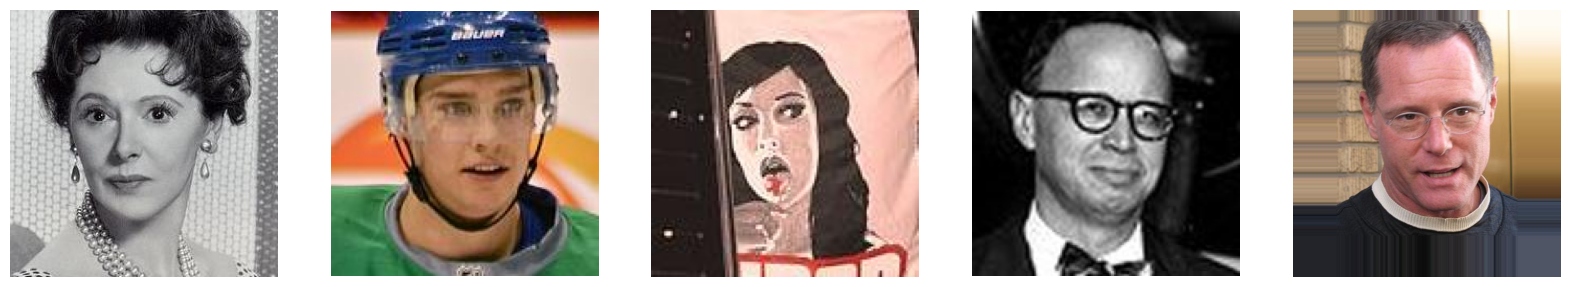

In [6]:
fig, axes = plt.subplots(1, 5, figsize=(20, 5))
for i, ax in enumerate(axes):
    ax.imshow(images.iloc[i]['image'])
    ax.axis('off')
plt.show()

In [7]:
def detect_face(frame):
    frame_current = frame.copy()
    frame_gray = frame_current
    
    shape_len = len(frame_current.shape)

    if shape_len == 3:
        frame_gray = cv2.cvtColor(frame_current, cv2.COLOR_RGB2GRAY)
        
    frame_gray = cv2.equalizeHist(frame_gray)
    #-- Detect faces
    faces = face_cascade.detectMultiScale(frame_gray)
    # detect eyes
    eyes = eyes_cascade.detectMultiScale(frame_gray)
    # check if there are any faces
    if len(faces) == 0 or len(eyes) != 2:
        return []
    
    eye_centers = []
    for (ex,ey,ew,eh) in eyes:
        eye_centers.append((ex + ew//2, ey + eh//2))

    eye_center1 = eye_centers[0]
    eye_center2 = eye_centers[1]

    dy = eye_center2[1] - eye_center1[1]
    dx = eye_center2[0] - eye_center1[0]
    angle = np.arctan2(dy, dx) * 180.0 / np.pi

    if abs(angle) > 10:
        return []
    
    return faces

In [8]:
image_faces = []

image_list = list(images['image'])

with concurrent.futures.ThreadPoolExecutor() as executor:
    futures = [executor.submit(detect_face, image) for image in image_list]
    for future in tqdm(concurrent.futures.as_completed(futures), total=len(images)):
        image_faces.append(future.result())
        
image_faces = np.array(image_faces)

  0%|          | 0/54258 [00:00<?, ?it/s]


error: OpenCV(4.8.1) d:\a\opencv-python\opencv-python\opencv\modules\objdetect\src\cascadedetect.hpp:46: error: (-215:Assertion failed) 0 <= scaleIdx && scaleIdx < (int)scaleData->size() in function 'cv::FeatureEvaluator::getScaleData'


In [ ]:
image_faces

In [29]:
cropped_faces = []

for i, image in enumerate(tqdm(images)):
    if len(image_faces[i]) == 0:
        continue
    
    for (x, y, w, h) in image_faces[i]:        
        cropped_faces.append(image[y:y + h, x:x + w])

100%|██████████| 62328/62328 [00:00<00:00, 2549394.69it/s]


In [30]:
for i, face in enumerate(tqdm(cropped_faces)):
    cv2.imwrite(FACES_FOLDER + image_paths[i].split('/')[-1], cv2.cvtColor(face, cv2.COLOR_RGB2BGR))

100%|██████████| 2979/2979 [00:01<00:00, 1586.21it/s]
